<a href="https://colab.research.google.com/github/AlexKalll/SSM-State-Space-Model/blob/main/Task_2_Temprature_Forecasting_Using_SSM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 2: Time-Series Temprature Prediction using SSM
**Objective: Predict daily temperature using a [Time-Series Data](https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data).**
### Sub-Tasks:
1. Preprocess data: Handle missing values, normalize, and split into sequences.
2. Implement discrete-time SSM variant (S4 in my case).
3. Train a PyTorch SSM to predict next-day temperatures.
4. Compare results against a simple LSTM baseline.



## Accessing and loading the dataset from Kaggle

---



In [5]:
import kagglehub

path = kagglehub.dataset_download("sumanthvrao/daily-climate-time-series-data")

print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/daily-climate-time-series-data


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import DataLoader, TensorDataset

In [7]:
train_path = '/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv'
test_path = '/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTest.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [8]:
train_df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [9]:
test_df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


## Preprocessing the data: Handle missing values, normalize, and split into sequences


In [44]:
# Check missing values
print("Missing in train:\n", train_df.isnull().sum())
print("Missing in test:\n", test_df.isnull().sum())

# Drop rows with missing values (safe here since few are missing)
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

# Select features and target
features = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']
target = 'meantemp'

train_features = train_df[features].values
test_features = test_df[features].values

# Normalization
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_features)
test_scaled = scaler.transform(test_features)

def create_sequences(data, seq_len=20):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len][0])
    return np.array(X), np.array(y).reshape(-1, 1)

seq_len = 20
X_train, y_train = create_sequences(train_scaled, seq_len)
X_test, y_test = create_sequences(test_scaled, seq_len)

X_train_tensor = torch.tensor(X_train).float()
y_train_tensor = torch.tensor(y_train).float()
X_test_tensor = torch.tensor(X_test).float()
y_test_tensor = torch.tensor(y_test).float()

# check dimensions
print("X_train:", X_train_tensor.shape)
print("y_train:", y_train_tensor.shape)
print("X_test:", X_test_tensor.shape)
print("y_test:", y_test_tensor.shape)

# Dataloader for training
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor),
                          batch_size=batch_size, shuffle=True)

Missing in train:
 date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64
Missing in test:
 date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64
X_train: torch.Size([1442, 20, 4])
y_train: torch.Size([1442, 1])
X_test: torch.Size([94, 20, 4])
y_test: torch.Size([94, 1])


In [11]:
for X_batch, y_batch in train_loader:
    print(X_batch.shape)
    print(y_batch.shape)
    break

torch.Size([32, 20, 4])
torch.Size([32, 1])


## Simplified Discrete-Time SSM (State Space Model-S4)

In [13]:
class S4M(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(S4M, self).__init__()
        self.A = nn.Parameter(torch.randn(hidden_dim, hidden_dim) * 0.1)
        self.B = nn.Parameter(torch.randn(input_dim, hidden_dim) * 0.1)
        self.C = nn.Parameter(torch.randn(hidden_dim, output_dim) * 0.1)
        self.D = nn.Parameter(torch.randn(input_dim, output_dim) * 0.1)
        self.x0 = nn.Parameter(torch.zeros(hidden_dim))  # Initial hidden state

    def forward(self, u):
        batch_size, seq_len, input_dim = u.shape
        x = self.x0.unsqueeze(0).repeat(batch_size, 1)  # (batch_size, hidden_dim)
        for t in range(seq_len):
            x = torch.tanh(x @ self.A + u[:, t, :] @ self.B)    # (batch_size, hidden_dim)
        y = x @ self.C + u[:, -1, :] @ self.D    # Output at final time step
        return y


## Training the Model

In [14]:
# Instantiate the model
input_dim = 4
hidden_dim = 32
output_dim = 1
s4_model = S4M(input_dim, hidden_dim, output_dim)

# Loss and optimizer
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(s4_model.parameters(), lr=0.01)

# Training loop
epochs = 500
print("Training S4-based SSM...")
for epoch in range(epochs):
    for X_batch, y_batch in train_loader:
        y_pred = s4_model(X_batch)
        loss = loss_func(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")


Training S4-based SSM...
Epoch 100/500, Loss: 0.0003
Epoch 200/500, Loss: 0.0015
Epoch 300/500, Loss: 0.0034
Epoch 400/500, Loss: 0.0015
Epoch 500/500, Loss: 0.0009


## Evaluate using the test dataset

Test MSE Loss: 0.0035


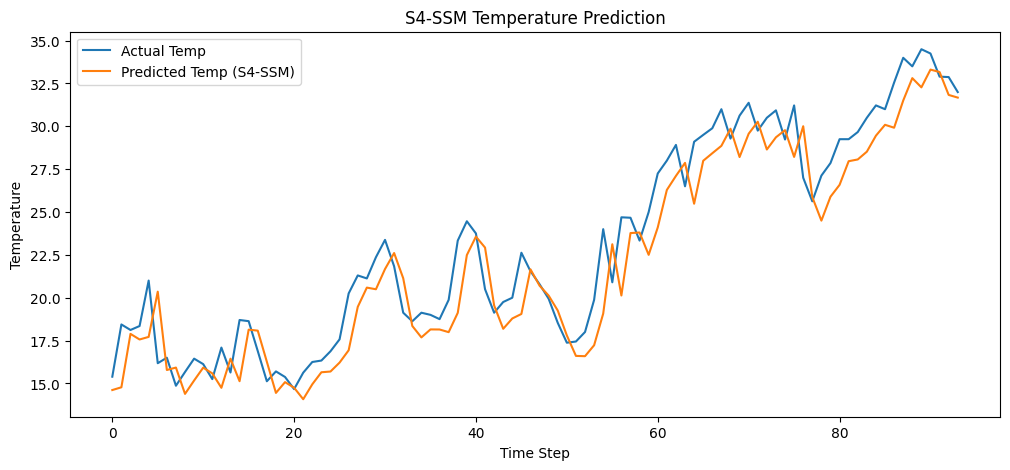

In [27]:
# Evaluation
s4_model.eval()
with torch.no_grad():
    test_preds = s4_model(X_test_tensor)
    test_loss = loss_func(test_preds, y_test_tensor)
    print(f"Test MSE Loss: {test_loss.item():.4f}")

    # Inverse scale predictions
    dummy_preds = np.zeros((len(test_preds), 4))
    dummy_preds[:, 0] = test_preds.squeeze().numpy()
    pred_temp = scaler.inverse_transform(dummy_preds)[:, 0]

    dummy_actual = np.zeros((len(y_test_tensor), 4))
    dummy_actual[:, 0] = y_test_tensor.squeeze().numpy()
    actual_temp = scaler.inverse_transform(dummy_actual)[:, 0]

    # plotting
    plt.figure(figsize=(12, 5))
    plt.plot(actual_temp, label='Actual Temp')
    plt.plot(pred_temp, label='Predicted Temp (S4-SSM)')
    plt.legend()
    plt.title('S4-SSM Temperature Prediction')
    plt.xlabel('Time Step')
    plt.ylabel('Temperature')
    plt.show()


In [28]:
# actualtemp_ssm = actual_temp
predtemp_ssm = pred_temp

## LSTM Baseline Model

In [16]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)  # out = (batch, seq_len, hidden_dim)
        out = self.fc(out[:, -1, :])  # output at last time step
        return out


## Instantiate and Train the LSTM model as well

In [17]:
# Initialize LSTM model
input_dim = 4
hidden_dim = 64
output_dim = 1
lstm_model = LSTM(input_dim, hidden_dim, output_dim)

# Loss and optimizer
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.01)


epochs = 500
print("Training LSTM model...")
for epoch in range(epochs):
    for X_batch, y_batch in train_loader:
        y_pred = lstm_model(X_batch)
        loss = loss_func(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

Training LSTM model...
Epoch 100/500, Loss: 0.0003
Epoch 200/500, Loss: 0.0006
Epoch 300/500, Loss: 0.0001
Epoch 400/500, Loss: 0.0006
Epoch 500/500, Loss: 0.0004


## Evaluate the LSTM model using the test dataset

LSTM Test MSE Loss: 0.0068


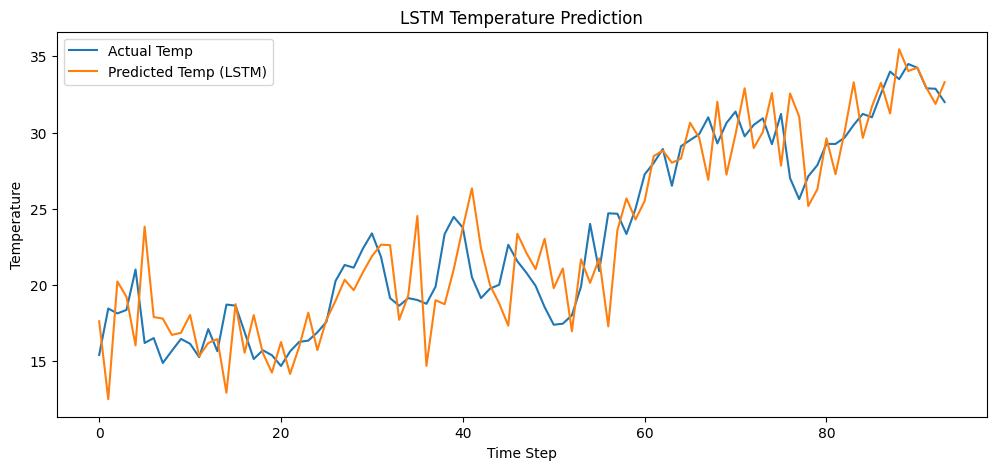

In [29]:
# Evaluation
lstm_model.eval()
with torch.no_grad():
    lstm_preds = lstm_model(X_test_tensor)
    lstm_loss = loss_func(lstm_preds, y_test_tensor)
    print(f"LSTM Test MSE Loss: {lstm_loss.item():.4f}")

    # Inverse scale predictions
    dummy_preds = np.zeros((len(lstm_preds), 4))
    dummy_preds[:, 0] = lstm_preds.squeeze().numpy()
    pred_temp = scaler.inverse_transform(dummy_preds)[:, 0]

    dummy_actual = np.zeros((len(y_test_tensor), 4))
    dummy_actual[:, 0] = y_test_tensor.squeeze().numpy()
    actual_temp = scaler.inverse_transform(dummy_actual)[:, 0]

    # plotting
    plt.figure(figsize=(12, 5))
    plt.plot(actual_temp, label='Actual Temp')
    plt.plot(pred_temp, label='Predicted Temp (LSTM)')
    plt.legend()
    plt.title('LSTM Temperature Prediction')
    plt.xlabel('Time Step')
    plt.ylabel('Temperature')
    plt.show()

In [30]:
# actualtemp_lstm = actual_temp
predtemp_lstm = pred_temp

## Side-by-Side Plot Comparision of both S4M and LSTM

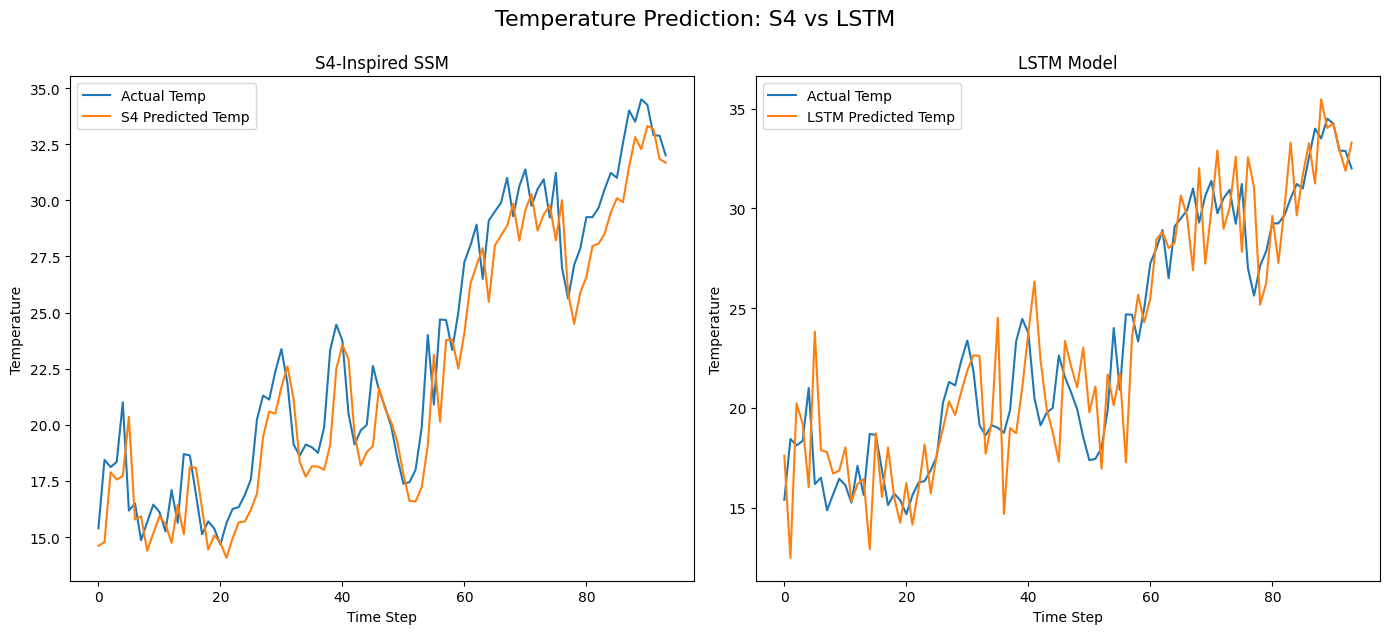

In [32]:
plt.figure(figsize=(14, 6))

# Plot S4 predictions
plt.subplot(1, 2, 1)
plt.plot(actual_temp, label='Actual Temp')
plt.plot(predtemp_ssm, label='S4 Predicted Temp')
plt.title("S4-Inspired SSM")
plt.xlabel("Time Step")
plt.ylabel("Temperature")
plt.legend()

# Plot LSTM predictions
plt.subplot(1, 2, 2)
plt.plot(actual_temp, label='Actual Temp')
plt.plot(predtemp_lstm, label='LSTM Predicted Temp')
plt.title("LSTM Model")
plt.xlabel("Time Step")
plt.ylabel("Temperature")
plt.legend()

plt.tight_layout()
plt.suptitle("Temperature Prediction: S4 vs LSTM", fontsize=16, y=1.05)
plt.show()


## Summary: MSE(mean squared error) and MAE(mean absolute error) for both models

In [36]:
# MSE & MAE for S4
mse_s4 = mean_squared_error(actual_temp, predtemp_ssm)
mae_s4 = mean_absolute_error(actual_temp, predtemp_ssm)

# MSE & MAE for LSTM
mse_lstm = mean_squared_error(actual_temp, predtemp_lstm)
mae_lstm = mean_absolute_error(actual_temp, predtemp_lstm)

comparision_df = pd.DataFrame({
    "Model": ["S4-M", "LSTM"],
    "MSE": [mse_s4, mse_lstm],
    "MAE": [mae_s4, mae_lstm]
})

In [42]:
print("Model Comparison Summary:")

comparision_df

Model Comparison Summary:


,Model,MSE,MAE
0,S4-M,3.709971,1.568394
1,LSTM,7.278689,2.044429


## Thanks for your time :) 🤝